In [49]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import json

from sklearn.cluster import KMeans

print(sns.__version__)
# Save a palette to a variable:
palette = sns.color_palette("bright")

sns.set_palette(palette)
sns.set(style="whitegrid", font_scale=2.5)


colors = ["#fc8d59", "#d73027", "#2e88df", "#762a81", "#99d594", "#3288bd"]
palette = sns.color_palette(colors, as_cmap=True)

seed = 1823492

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0.13.2


In [74]:
PROCESSED_PATH = "/m/cs/work/luongn1/digirhythm/data/processed"
study = "corona"
freq = "4epochs"

threshold = 2
with open(f"../config/features.txt") as f:
    features = json.load(f)

FEATURES = features[study][freq]
method = "cluster"
baseline_diff_cluster = pd.read_csv(
    f"{PROCESSED_PATH}/{study}/{freq}_{method}_threshold_2_diff_baseline.csv"
)

method = "si"
baseline_diff_si = pd.read_csv(
    f"{PROCESSED_PATH}/{study}/{freq}_{method}_threshold_1.85_diff_baseline.csv"
)

# Get outlier
outliers_cluster = baseline_diff_cluster.query("outlier == True")
outliers_cluster["type"] = "cluster"
outliers_si = baseline_diff_si.query("outlier == True")
outliers_si["type"] = "si"

# Find overlap
outliers = pd.concat([outliers_cluster, outliers_si], axis=0)
outliers

/tmp/ipykernel_3553351/99257146.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_cluster['type'] = 'cluster'
/tmp/ipykernel_3553351/99257146.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outliers_si['type'] = 'si'


,heart_rate_variability_avg:within_norm,stepsx1000:total:within_norm,steps:night:norm,steps:morning:norm,steps:afternoon:norm,steps:evening:norm,tst:within_norm,midsleep:within_norm,cluster,subject_id,date,sim_to_centroid,outlier,type,sim_to_baseline
69,-0.187963,-0.096718,0.091445,0.008790,-0.344676,0.244440,-0.195578,0.294125,0.0,38758730,2022-05-18,0.626165,True,cluster,NaN
70,0.038704,-0.038067,0.010679,-0.273675,0.365142,-0.102146,-0.167321,-0.233148,0.0,38758730,2022-05-19,0.644566,True,cluster,NaN
83,-0.306667,0.177008,0.375022,-0.078410,-0.130716,-0.165896,-0.002747,0.078788,1.0,38758730,2021-10-24,0.637624,True,cluster,NaN
101,0.608889,-0.065258,-0.015053,-0.041692,-0.028655,0.085400,0.078736,0.025036,2.0,38758730,2021-07-30,0.614996,True,cluster,NaN
188,-0.032336,-0.057102,-0.008518,-0.200508,-0.185230,0.394257,0.175738,-0.004467,3.0,38758730,2021-07-21,0.660062,True,cluster,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26368,-0.129568,-0.450744,0.998931,-0.409476,-0.411649,-0.177806,-0.032430,-0.022419,NaN,4270145196,2021-07-26,NaN,True,si,0.442438
26491,0.068106,-0.091218,-0.001069,-0.315869,0.396629,-0.079692,0.451765,0.244004,NaN,4270145196,2022-01-08,NaN,True,si,0.576413
26492,-0.141196,-0.449879,0.998931,-0.409476,-0.411649,-0.177806,0.371305,0.087070,NaN,4270145196,2022-01-09,NaN,True,si,0.431600
26495,-0.094684,-0.202717,0.003068,-0.378342,0.427889,-0.052615,0.348317,0.225756,NaN,4270145196,2022-01-29,NaN,True,si,0.573876


In [75]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


def analyze_clusters(data, features, seed=0):
    """
    Analyze clusters within the given dataset using KMeans clustering.

    Parameters:
        data (DataFrame): The dataset containing the features.
        features (list): List of column names to use for clustering.
        seed (int): Random seed for reproducibility.

    Returns:
        None
    """
    # Determine the optimal cluster number with the elbow method and silhouette scores
    wcss = []
    silhouette_scores = []
    for i in range(2, 11):
        model = KMeans(
            n_clusters=i, init="k-means++", max_iter=300, n_init=10, random_state=seed
        )
        labels = model.fit_predict(data[features])

        # Silhouette Index
        silhouette_avg = silhouette_score(data[features], labels)
        silhouette_scores.append(silhouette_avg)

    optimal_clusters_silhouette = np.argmax(silhouette_scores) + 2
    print("Optimal number of clusters: ", optimal_clusters_silhouette)

    # Applying KMeans with the optimal number of clusters
    kmeans = KMeans(
        n_clusters=optimal_clusters_silhouette,
        init="k-means++",
        max_iter=300,
        n_init=10,
        random_state=seed,
    )
    data["outlier_cluster"] = kmeans.fit_predict(data[features]) + 1

    # Calculate median values per cluster for numeric columns
    cluster_median = data.groupby("outlier_cluster").median(numeric_only=True)

    # Calculate the percentage of each cluster
    cluster_counts = data["outlier_cluster"].value_counts().sort_index()
    cluster_percentages = (cluster_counts / len(data) * 100).round(
        2
    )  # Percentages rounded to 2 decimal places

    if False:
        # Display the results
        print("Median values per cluster:")
        print(cluster_median)
        print("\nPercentage of each cluster membership:")
        print(cluster_percentages)

    return data


# Example usage:
# Assuming 'outliers' is your DataFrame and 'FEATURES' contains your feature column names
si = analyze_clusters(outliers_si, FEATURES)
cl = analyze_clusters(outliers_cluster, FEATURES)

Optimal number of clusters:  8


/tmp/ipykernel_3553351/230970039.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['outlier_cluster'] = kmeans.fit_predict(data[features]) + 1


Optimal number of clusters:  8


/tmp/ipykernel_3553351/230970039.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['outlier_cluster'] = kmeans.fit_predict(data[features]) + 1


In [76]:
m = si.merge(cl, on=["subject_id", "date"])


# Assuming df is your DataFrame
# Automatically find matching pairs of columns ending in _x and _y
suffix_pairs = ["_x", "_y"]
column_pairs = {}

# Group columns by their root name (minus _x or _y)
for col in m.columns:
    for suffix in suffix_pairs:
        root_name = col[:-2]
        if (
            col.endswith(suffix)
            and root_name + "_x" in m.columns
            and root_name + "_y" in m.columns
        ):
            column_pairs[root_name] = (root_name + "_x", root_name + "_y")

# Compute differences for each pair and add to DataFrame
for root, (col_x, col_y) in column_pairs.items():
    if m[col_x].dtypes == "float":
        m[root + "_diff"] = m[col_x] - m[col_y]

# Output the updated DataFrame
m["steps:afternoon:norm_diff"].describe()

count    393.000000
mean      -0.030917
std        0.168731
min       -0.478033
25%       -0.163861
50%       -0.064140
75%        0.094744
max        0.423848
Name: steps:afternoon:norm_diff, dtype: float64

In [78]:
# Overlapped ratio
print("SI:", len(si))
print("Cluster:", len(cl))
print("Overlap:", len(m))

SI: 808
Cluster: 881
Overlap: 393


36.5

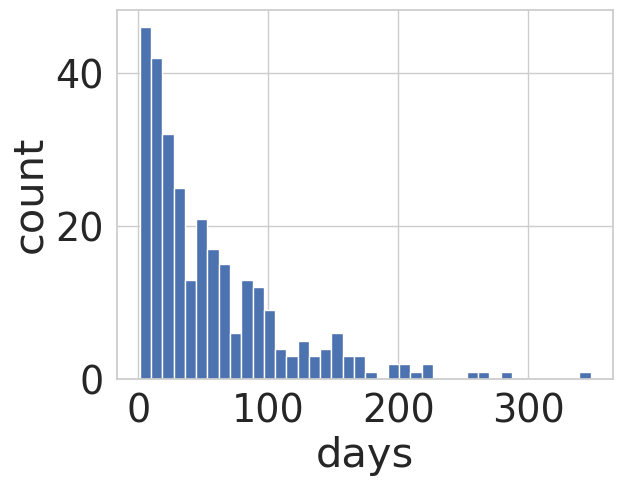

In [85]:
# Count how many consecutive days in each cluster
# Sort by subject_id and date
df_sorted = m.copy()
df_sorted.date = pd.to_datetime(df_sorted.date)
df_sorted = df_sorted.sort_values(by=["subject_id", "date"])

# Compute date differences within each subject
df_sorted["date_diff"] = df_sorted.groupby("subject_id")["date"].diff().dt.days
# df_sorted[df_sorted.date_diff<10].date_diff.hist(bins=40)
df_sorted.date_diff.hist(
    bins=40,
)
plt.xlabel("days")
plt.ylabel("count")

df_sorted.date_diff.median()